### Haiku datasets

https://www.kaggle.com/datasets/bfbarry/haiku-dataset

Using HuggingFace Dataset to load

In [1]:
# Libraries 
import torch
from datasets import load_dataset
import os
import pickle
import random
random.seed(1330) 

#Note: I lowered the learning rate to 3e-5 after 20000 itterations

In [2]:
ds = load_dataset("statworx/haiku")
haikutext = '\n'.join(ds['train']['text'])

In [7]:
vocab_size

86

In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(haikutext)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [47]:
data = torch.tensor(encode(haikutext), dtype=torch.long)

#train test split
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Model Train

In [5]:
# hyperparameters

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #m1 gpu
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 256 # what is the maximum context length for predictions
max_iters = 10000 # epochs/learning iterations
eval_interval = 100 # for printing loss updates
checpoint_interval = 1000 #save checkpoint
learning_rate = 3e-4 # Slower learning rate for wide model
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
n_block_layers = 6
dropout = 0.2

In [6]:
from BigramLanguageModelTrain import utilTools as ut
from BigramLanguageModelTrain import BigramLanguageModel


#Relearning Epoch starting point
iterationStart = 20000


#Stopping criteria parameters
patience = 8
best_val_loss = float('inf')
epochs_no_improve = 0


util_tools = ut(train_data, val_data, block_size, batch_size, device)
model = BigramLanguageModel(block_size, vocab_size, n_embd, n_head, dropout, device)

if os.path.exists(f'.lossesSimpleEncode/trainlosses_{iterationStart}.pkl'):
    with open(f'.lossesSimpleEncode/trainlosses_{iterationStart}.pkl', "rb") as file:
        trainlosses = pickle.load(file)
else:
    trainlosses = []

if os.path.exists(f'.lossesSimpleEncode/vallosses_{iterationStart}.pkl'):
    with open(f'.lossesSimpleEncode/vallosses_{iterationStart}.pkl', "rb") as file:
        vallosses = pickle.load(file)
else:
    vallosses = []


if os.path.exists(f'./model_weightsSimpleEncode/model_weights_{iterationStart}.pth'):
    print("Loading from previous checkpoint", f"'./model_weightsSimpleEncode/model_weights_{iterationStart}.pth'")
    # Load previous weights
    model.load_state_dict(torch.load(f'./model_weightsSimpleEncode/model_weights_{iterationStart}.pth', weights_only=True))

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = util_tools.estimate_loss(model, eval_iters)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trainlosses.append(losses['train'])
        vallosses.append(losses['val'])

        #Stopping Criteria
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print("Early stopping")
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            break
    if iter % checpoint_interval ==0 and iter >0:
        # Save the weights checkpoint
        torch.save(model.state_dict(), f"./model_weightsSimpleEncode/model_weights_{iter+iterationStart}.pth")

    # sample a batch of data
    xb, yb = util_tools.get_batch(split ='train')
    xb, yb = xb.to(device), yb.to(device)


    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
print("Train complete")
# Save the weights
torch.save(model.state_dict(), f"./model_weightsSimpleEncode/model_weights_{max_iters+iterationStart}.pth")
with open(f"./lossesSimpleEncode/trainlosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(trainlosses, file)
with open(f"./lossesSimpleEncode/vallosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(vallosses, file)

NameError: name 'train_data' is not defined

# Losses

In [98]:
def load_pkl_file(file_path):
    with open(file_path, 'rb') as file:
        return list(pickle.load(file))
    
trainlossfile = sorted([item for item in os.listdir('./lossesSimpleEncode') if 'train' in item])
vallossfile = sorted([item for item in os.listdir('./lossesSimpleEncode') if 'val' in item])
traininglosses = []
vallosses = []
for i in range(0, len(trainlossfile)):
    traininglosses.extend(load_pkl_file(f'./lossesSimpleEncode/{trainlossfile[i]}'))
    vallosses.extend(load_pkl_file(f'./lossesSimpleEncode/{vallossfile[i]}'))

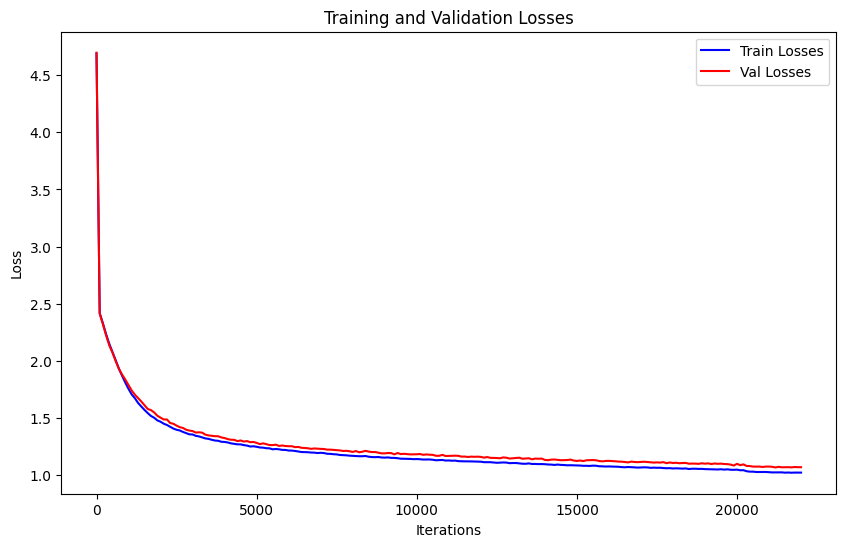

In [101]:
import matplotlib.pyplot as plt
# Create the plot
x_values = list(range(0,len(traininglosses)*100,100))
plt.figure(figsize=(10, 6))

# Plot the training losses
plt.plot(x_values, traininglosses, label='Train Losses', color='blue')
# Plot the validation losses
plt.plot(x_values, vallosses, label='Val Losses', color='red')
# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
# Add a legend
plt.legend()
# Show the plot
plt.show()

In [71]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


Free within Adam. / The screen elightens.
Thunder shadows. / Fills the witcomer words. / Shreet in cicadas.
Graffiti. / A dream. / By the apper curve.
This year. / Coque dog. / To fill the line.
Marigold apples. / The doves of the school. / From breakfast train.
Her edges. / [Talling sigh. / Fuck over belly]
From the milk. / The trees willow. / To soaked.
Between sunflaness days. / Face to his feet. / Like the taking stillness.
That dream distance. / Tears your face flows to you cry ephen. / I shopa before that.
Do you huckly through? / A simple letter down low. / Elects this week.
Voters of life shit. / We can raising rhymore? / Of her thin bitch will.
A sun roads on my sugar. / Wintly the last night rain. / Coyotes into each hope.
Name was just dancing. / My jar bicy lifts seventh wings. / Border now flooding.
Winter sleeping in. / How did I feel you know? / I can miss Ian.
Except sarcasses. / The normal harvest around. / Suckle date everywhen.
The writer clouds leave. / Parchated s

In [76]:
import nltk
from nltk.corpus import words
import re

# Download the words corpus (if you haven't already)
nltk.download('words')

# Get the list of valid English words from nltk corpus
valid_words = set(words.words())

def percentage_real_words(input_string):
    # Remove non-alphabetic characters and split the string into words
    word_list = re.findall(r'\b[a-zA-Z]+\b', input_string)
    
    # Count the real words
    real_word_count = sum(1 for word in word_list if word.lower() in valid_words)
    
    # Calculate the percentage of real words
    if len(word_list) == 0:
        return 0  # To avoid division by zero
    return (real_word_count / len(word_list)) * 100

# Example usage
input_string = decode(model.generate(context, max_new_tokens=10000)[0].tolist())
real_word_percentage = percentage_real_words(input_string)
print(f"Percentage of real words: {real_word_percentage:.2f}%")

[nltk_data] Downloading package words to
[nltk_data]     /Users/clayolsen1/nltk_data...
[nltk_data]   Package words is already up-to-date!


Percentage of real words: 85.39%
